In [1]:
import sys, os
import numpy as np

sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.phasediagram import PETScPDReactiveODE, PDReactiveGrid, PDReactiveGridDiagnostics
from tcg_slb.base import *

%matplotlib widget

In [2]:
pv = repr(sys.version_info.major)+'.'+repr(sys.version_info.minor)
sys.path.append(os.path.join(os.path.pardir, 'database', 'install', 'MgFeSiO4_all_slb_rx', 'lib', 'python'+pv, 'site-packages'))

import py_MgFeSiO4_all_slb_rx as tcgdb
rxn = tcgdb.MgFeSiO4_all_slb_rx()
rxn.report()

Reaction object: MgFeSiO4_all_slb_rx

Phase 0 Olivine_slb_ph (ol)
     Endmember 0 Forsterite_slb_em : Mg2SiO4_(ol)
     Endmember 1 Fayalite_slb_em : Fe2SiO4_(ol)
Phase 1 Wadsleyite_slb_ph (wa)
     Endmember 0 MgWadsleyite_slb_em : Mg2SiO4_(wa)
     Endmember 1 FeWadsleyite_slb_em : Fe2SiO4_(wa)
Phase 2 Ringwoodite_slb_ph (ri)
     Endmember 0 MgRingwoodite_slb_em : Mg2SiO4_(ri)
     Endmember 1 FeRingwoodite_slb_em : Fe2SiO4_(ri)
Phase 3 MgFePerovskite_slb_ph (mgfepv)
     Endmember 0 MgPerovskite_slb_em : MgSiO3_(mgfepv)
     Endmember 1 FePerovskite_slb_em : FeSiO3_(mgfepv)
Phase 4 Magnesiowuestite_slb_ph (mw)
     Endmember 0 Periclase_slb_em : MgO_(mw)
     Endmember 1 Wuestite_slb_em : FeO_(mw)
Phase 5 Stishovite_slb_ph (st)
     Endmember 0 Stishovite_slb_em : SiO2_(st)

Reaction 0
     Mg2SiO4_(ol) -> Mg2SiO4_(wa)
Reaction 1
     Fe2SiO4_(ol) -> Fe2SiO4_(wa)
Reaction 2
     Mg2SiO4_(ol) -> Mg2SiO4_(ri)
Reaction 3
     Fe2SiO4_(ol) -> Fe2SiO4_(ri)
Reaction 4
     Mg2SiO4_(wa) 

### Setup ODE

In [3]:
ode = PETScPDReactiveODE(rxn)

In [18]:
import dolfin as df

df.UserExpression().eval_cell?

Object `eval_cell` not found.


In [19]:
rxn.phases()[0].abbrev()

'ol'

#### Temperature, pressure, composition

In [4]:
# initial temperature, pressure and phase volume fraction
Ti = 1673.                # Kelvin
pi = GPa2Bar(30.)         # bars
Ci0 = [0.8, 0.2]
i0 =  0                   # initial phase index
pi

300000.0

#### Initial conditions

In [5]:
Fi = np.zeros(ode.I)
Fi[i0] = 1.
Cik = np.zeros(ode.K)
for i in range(ode.I):
    if ode.Kis[i] == 1:
        Cik[sum(ode.Kis[:i]):sum(ode.Kis[:i+1])] = 1.
    else:
        Cik[sum(ode.Kis[:i]):sum(ode.Kis[:i+1])][:2] = np.asarray(Ci0)
        

u0=np.empty(ode.I+ode.K)
u0[:ode.I] = Fi
u0[ode.I:ode.I+ode.K] = Cik
print(u0)

[1.  0.  0.  0.  0.  0.  0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 1. ]


### Solve the system of reactive ODEs at a fixed pressure and temperature

In [6]:
ode.solve(Ti,pi,Fi,Cik,1.0)

In [7]:
ode.stime

0.9420349060092121

In [8]:
ode.final_phases(1.e-2)

(array(['Olivine_slb_ph', 'Wadsleyite_slb_ph', 'Ringwoodite_slb_ph',
        'MgFePerovskite_slb_ph', 'Magnesiowuestite_slb_ph',
        'Stishovite_slb_ph'], dtype='<U23'),
 array(['ol', 'wa', 'ri', 'mgfepv', 'mw', 'st'], dtype='<U6'))

## Plotting

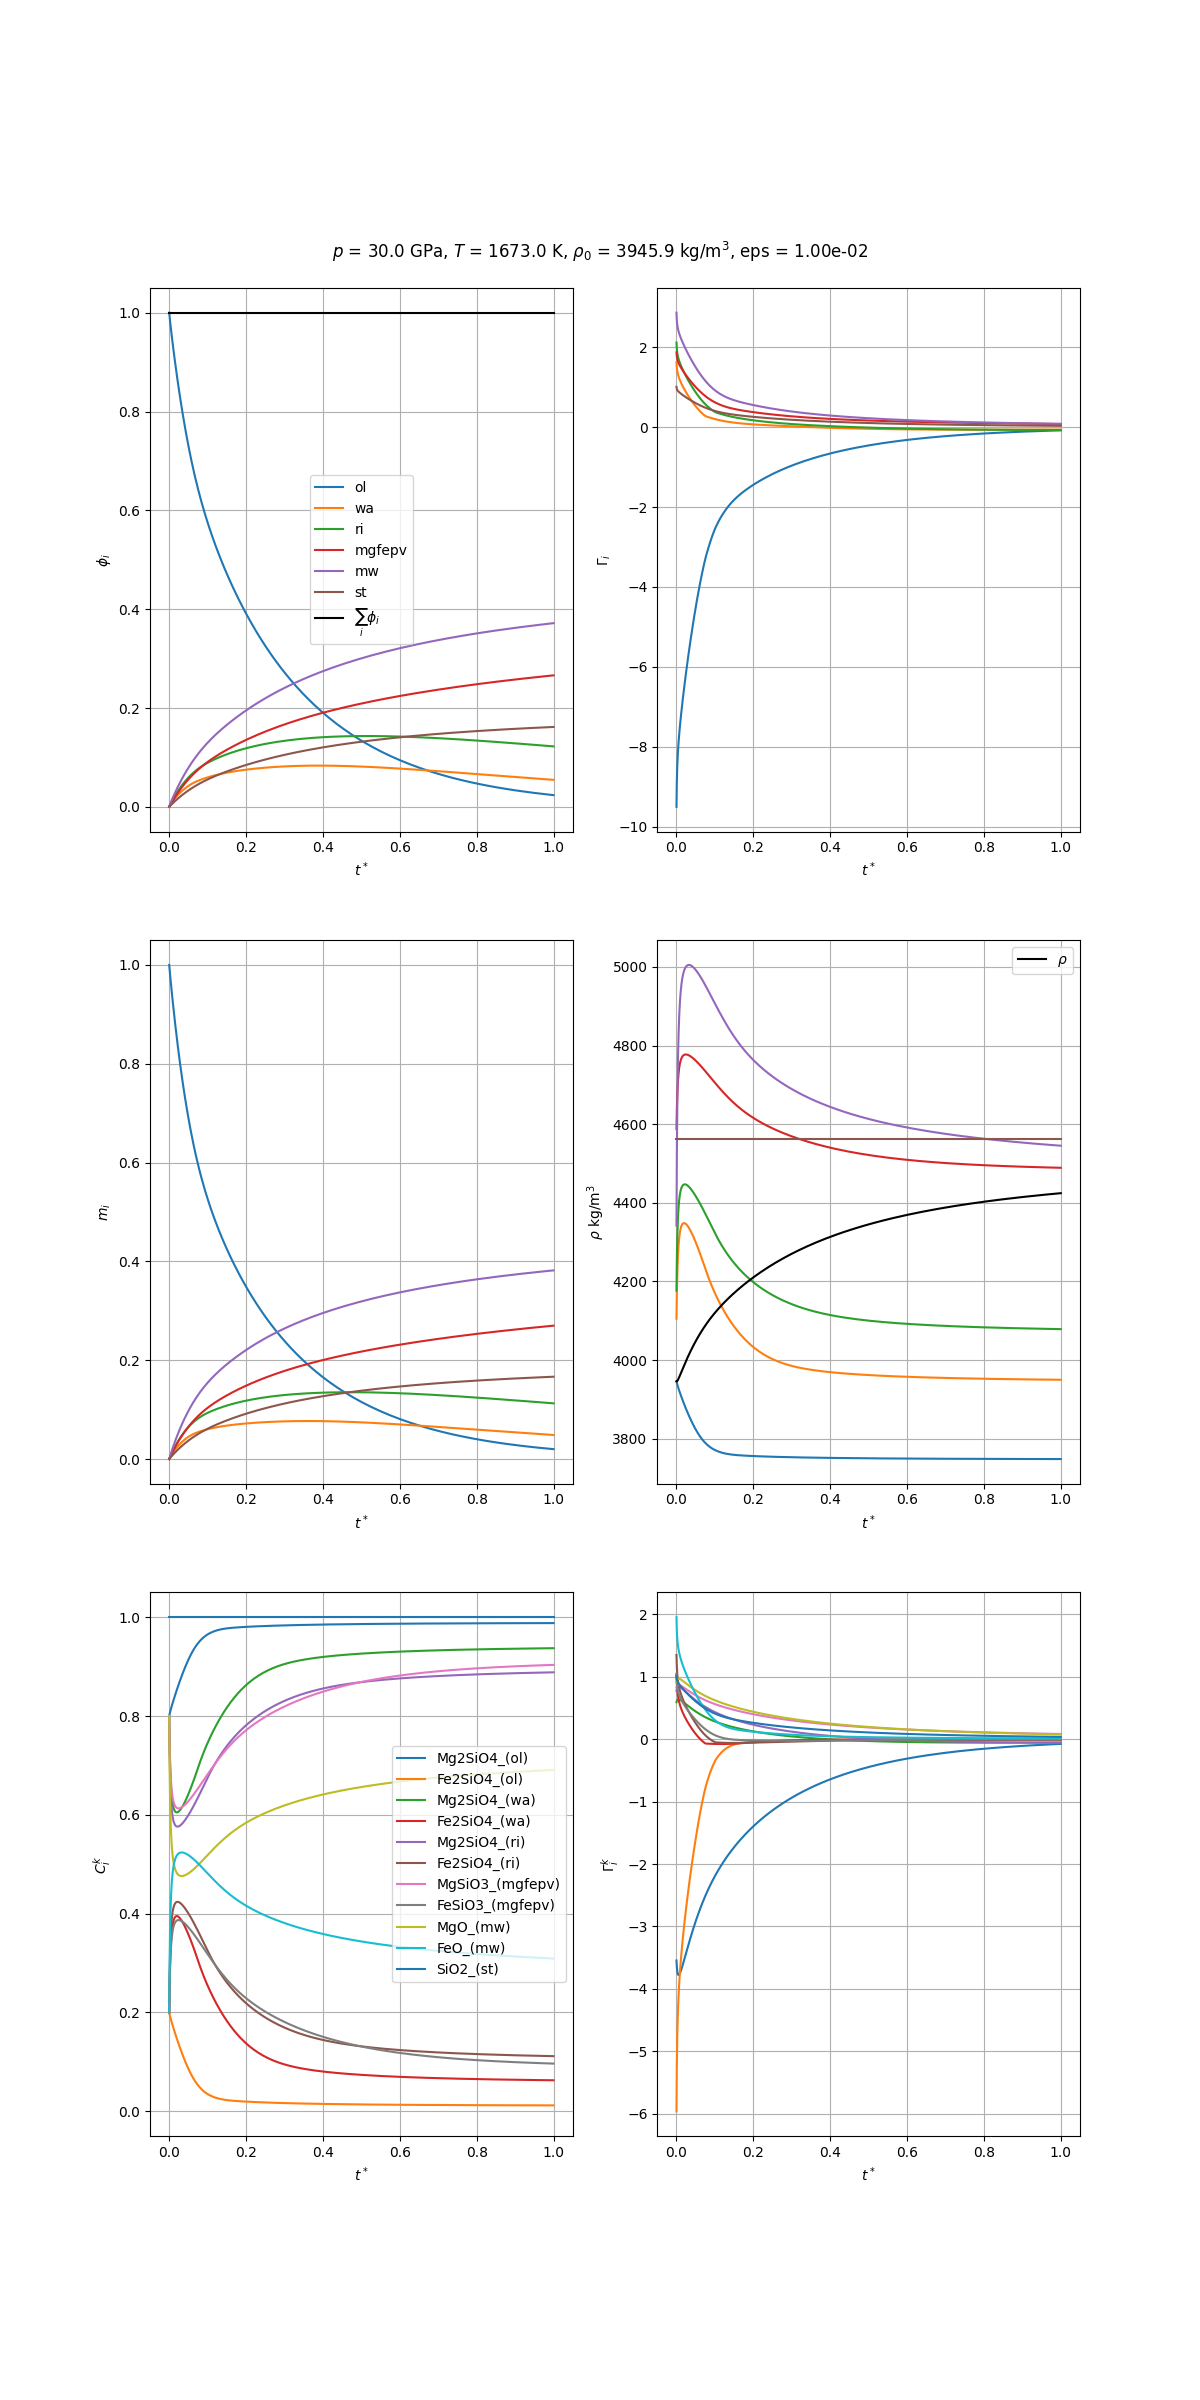

In [9]:
ode.plot()

## Solve for a grid

In [12]:
reload = True

import pickle
if reload:
    pfile = open(os.path.join('output', 'petsc_bdfgrid_mgfesio4_lowp.pickle'), 'rb')
    bdfgrid = pickle.load(pfile)
    pfile.close()
else:
    i0 = 0
    p_min = 11.1864406779661
    p_max = 13.728813559322033
    x_min = 0.02767445
    x_max = 1.0
    nx = 2  # number of grid points in composition
    ny = 7  # number of grid points in pressure
    end = 1e6
    bdfgrid = PDReactiveGrid()
    bdfgrid.solve(rxn, PETScPDReactiveODE, Ti, i0, p_min, p_max, nx, ny, end)
    pfile = open(os.path.join('output', 'petsc_bdfgrid_mgfesio4_lowp.pickle'), 'wb')
    pickle.dump(bdfgrid, pfile)
    pfile.close()

KeyboardInterrupt: 

In [ ]:
bdfdiag = PDReactiveGridDiagnostics(rxn,bdfgrid)

In [ ]:
bdfdiag.plot_phases()

In [ ]:
bdfdiag.plot_rho()

In [ ]:
bdfdiag.plot_stime()

In [ ]:
bdfdiag.plot_mindt()

In [ ]:
bdfdiag.plot_ndt()

In [ ]:
bdfdiag.plot_Xi1()